#Set up  
Download and import all necessary libraries


In [ ]:
!export CUDA_VISIBLE_DEVICES=1
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import glob
import re
import numpy as np
import torch
import gc
import cv2
from PIL import Image
import av
import imageio
from transformers import LlavaNextVideoProcessor, LlavaNextVideoForConditionalGeneration, BitsAndBytesConfig
from sentence_transformers import SentenceTransformer, util
import logging
import time
import pandas as pd
import json
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import traceback
import string
from typing import List, Optional, Tuple
from collections import defaultdict
import nltk
nltk.download('punkt')
from rouge_score import rouge_scorer

##### Configuration 
-Sets up logging
-inputs and outputs paths  
-models ID and parameters

Configure utilities function for prompting  
Configure evaluation function  
Configure visualisation of attention maps


In [ ]:
warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Configuration
original_video_dir = "/home/kassandralea.briola/Project/VideoCheck"
mask_dir_base = "/home/kassandralea.briola/Project/output/masks"
model_id = "llava-hf/llava-next-video-7b-hf"
target_size = 224
patch_size = 16
max_frames = 24

GROUND_TRUTH_PATH = "/home/kassandralea.briola/Project/GroundTruth/ground_truth_answer.json"
OUTPUT_DIR = "/home/kassandralea.briola/Project/output"
DETAILED_TABLE_PATH = os.path.join(OUTPUT_DIR, "detailed_evaluation_table.csv")
SUMMARY_TABLE_PATH = os.path.join(OUTPUT_DIR, "summary_accuracy_table.csv")
PROMPTS_JSON_PATH = '/home/kassandralea.briola/Project/GroundTruth/prompts.json'


# Load ground truth answers
try:
    with open(GROUND_TRUTH_PATH, 'r') as f:
        ground_truth = json.load(f)
except FileNotFoundError:
    logger.error(f"Ground truth file not found at {GROUND_TRUTH_PATH}")
    ground_truth = {}

# --- Prompt Configuration ---
def load_prompts_from_file():
    try:
        with open(PROMPTS_JSON_PATH, 'r') as f:
            prompts = json.load(f)
        print(f"Loaded {len(prompts)} prompts from {PROMPTS_JSON_PATH}")
        return prompts
    except Exception as e:
        print(f"Error loading prompts.json: {e}")
        return {}

def clean_text(text):
    return text.lower().translate(str.maketrans('', '', string.punctuation)).strip()

def split_questions(prompt_text):
    # splits questions by numbers at the start of each question
    questions = re.split(r'\d+\.\s*', prompt_text)
    # Remove any empty strings
    questions = [q.strip() for q in questions if q.strip()]
    if len(questions) > 1 and not any(word in questions[0].lower() for word in ["?", "what", "how", "why", "list"]):
        questions = questions[1:]
    return questions

def categorize_question(question_text):
    question_text = question_text.lower().strip()
    open_ended_keywords = [
        "why", "describe", "explain", "reason", "cause", "effect", "list"
    ]
    # Remove punctuation for matching
    question_text_clean = re.sub(r'[^\w\s]', '', question_text)
    words = question_text_clean.split()
    if words and words[0] in open_ended_keywords:
        return "open-ended"
    for keyword in open_ended_keywords:
        if keyword in question_text_clean:
            return "open-ended"
    return "categorical"

# --- Visualization Utility ---
def save_attention_overlay(frame, attn_map, save_path, title=None, cmap='jet', alpha=0.5):
    plt.figure(figsize=(6, 6))
    if isinstance(frame, Image.Image):
        frame_np = np.array(frame)
    else:
        frame_np = frame
    plt.imshow(frame_np)
    if attn_map is not None:
        plt.imshow(attn_map, cmap=cmap, alpha=alpha)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()

def visualize_attention_for_mode(video_name, mode, frames, masks=None, output_base="attention_maps"):
    mode_dir = os.path.join(output_base, video_name, mode)
    os.makedirs(mode_dir, exist_ok=True)
    logger.debug(f"Visualizing attention for {video_name} in mode {mode}, {len(frames)} frames")
    for idx, frame in enumerate(frames):
        try:
            logger.debug(f"Processing frame {idx}, frame type: {type(frame)}")
            if mode == "original":
                attn_map = np.ones(frame.size[::-1]) if isinstance(frame, Image.Image) else np.ones(frame.shape[:2])
            elif mode == "crop-and-mask":
                mask = masks[idx] if masks and idx < len(masks) else None
                attn_map = mask if mask is not None else np.zeros(frame.size[::-1] if isinstance(frame, Image.Image) else frame.shape[:2])
            else:
                logger.warning(f"Unsupported mode {mode} for visualization")
                continue
            save_path = os.path.join(mode_dir, f"frame_{idx:03d}.png")
            save_attention_overlay(frame, attn_map, save_path, title=f"{mode} - frame {idx}")
        except Exception as e:
            logger.error(f"Failed to visualize frame {idx} for {video_name} in mode {mode}: {str(e)}")
            continue

# --- Evaluation Functions ---
def evaluate_responses(video_id, model_answers, ground_truth, prompt, st_model):
    if video_id not in ground_truth or not model_answers:
        logger.warning(f"No ground truth for video {video_id} or no model answers provided")
        return {}

    gt_answers = ground_truth[video_id]
    results = {}
    for q_key in gt_answers:
        question_text = prompt.get(q_key, "")
        model_ans = model_answers.get(q_key, "")
        gt_info = gt_answers[q_key]
        # Support both old and new JSON formats
        if isinstance(gt_info, dict):
            gt_ans = gt_info.get("answer", "")
            keywords = gt_info.get("keywords", [])
        else:
            gt_ans = gt_info
            keywords = []
        category = categorize_question(question_text)

        metrics = {"category": category}

        if category == "categorical":
            model_ans_lower = model_ans.lower()
            pred_label = None
            for kw in keywords:
                if kw.lower() in model_ans_lower:
                    pred_label = kw.lower()
                    break
            # Compute semantic similarity for categorical as well
            try:
                emb_model = st_model.encode([model_ans.strip(), gt_ans.strip()])
                sim_score = util.cos_sim(emb_model[0], emb_model[1]).item()
            except Exception:
                sim_score = 0.0
            # Accept if keyword match OR semantic similarity is high
            metrics["keyword_accuracy"] = int((pred_label is not None) or (sim_score > 0.8))
            metrics["semantic_similarity"] = sim_score
            metrics["predicted_label"] = pred_label
            metrics["ground_truth_label"] = gt_ans.lower().strip()
        else:
            # Only semantic similarity for open-ended
            try:
                emb_model = st_model.encode([model_ans.strip(), gt_ans.strip()])
                metrics["semantic_similarity"] = util.cos_sim(emb_model[0], emb_model[1]).item()
            except Exception:
                metrics["semantic_similarity"] = 0.0
            metrics["keyword_accuracy"] = None
            metrics["predicted_label"] = None
            metrics["ground_truth_label"] = None
        results[q_key] = {
            "question": question_text,
            "ground_truth": gt_ans,
            "model_answer": model_ans,
            **metrics
        }
    return results

In [ ]:
#Vision-only Self-Attention
def extract_framewise_attention(model, frames):
    """
    Extracts attention weights for each frame (image) individually.
    Returns a list of attention matrices, one per frame.
    """
    vision_tower = model.vision_tower
    vision_model = vision_tower.vision_model
    device = next(vision_model.parameters()).device

    attn_per_frame = []
    for i, frame in enumerate(frames):
        # Resize frame to 336x336 as required by the model
        if isinstance(frame, Image.Image):
            frame_resized = frame.resize((336, 336), Image.BICUBIC)
            frame_np = np.array(frame_resized)
        else:
            frame_resized = cv2.resize(frame, (336, 336), interpolation=cv2.INTER_CUBIC)
            frame_np = frame_resized
        if frame_np.shape[-1] == 3:
            frame_np = frame_np.transpose(2, 0, 1)  # (3, H, W)
        frame_tensor = torch.from_numpy(frame_np).unsqueeze(0).float().to(device)  # (1, 3, H, W)

        with torch.no_grad():
            outputs = vision_model(
                pixel_values=frame_tensor,
                output_attentions=True,
                return_dict=True
            )
        if outputs.attentions is not None and len(outputs.attentions) > 0:
            attn_layers = []
            for attn in outputs.attentions:
                attn_mean = attn.mean(dim=(0,1))  # (tokens, tokens)
                attn_layers.append(attn_mean.cpu())
            attn_per_frame.append(torch.stack(attn_layers))  # (layers, tokens, tokens)
        else:
            attn_per_frame.append(None)
    return attn_per_frame  # List of (layers, tokens, tokens)

def plot_layer_vs_frame_attention(attn_per_frame, save_path=None):
    """
    Plots a heatmap with y-axis as layers and x-axis as frames.
    Each cell shows the mean attention (over tokens) for that layer and frame.
    """
    # attn_per_frame: list of (layers, tokens, tokens)
    # We'll take mean over tokens for each (layers, tokens, tokens) -> (layers,)
    layer_frame_matrix = []
    for i, attn_stack in enumerate(attn_per_frame):
        if attn_stack is not None:
            # Mean attention over all tokens (excluding CLS if you want)
            mean_per_layer = attn_stack[:, 0, 1:].mean(dim=1).cpu().numpy()  # shape: (layers,)
            layer_frame_matrix.append(mean_per_layer)
        else:
            # If attention missing for a frame, fill with NaN
            layer_frame_matrix.append(np.full(attn_per_frame[0].shape[0], np.nan))
    # Now: shape = (frames, layers) -> transpose to (layers, frames)
    layer_frame_matrix = np.stack(layer_frame_matrix, axis=0).T  # (layers, frames)

    # --- Normalize each layer (row) separately from 0 to 1 ---
    for i in range(layer_frame_matrix.shape[0]):
        row = layer_frame_matrix[i]
        min_val = np.nanmin(row)
        max_val = np.nanmax(row)
        if max_val > min_val:
            layer_frame_matrix[i] = (row - min_val) / (max_val - min_val)
        else:
            layer_frame_matrix[i] = 0  # or np.nan if you prefer

    plt.figure(figsize=(10, 6))
    sns.heatmap(layer_frame_matrix, cmap='viridis', xticklabels=True, yticklabels=True)
    plt.xlabel("Frame Index")
    plt.ylabel("Layer")
    plt.title("Mean Attention per Layer vs Frame (Normalized)")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()
    plt.close()

def plot_mean_attention_over_frames(attn_per_frame, save_path=None):
    """
    Plots the mean attention (averaged over all layers and tokens) for each frame.
    """
    # attn_per_frame: list of (layers, tokens, tokens)
    mean_per_frame = []
    for attn_stack in attn_per_frame:
        if attn_stack is not None:
            # Mean over all layers and all tokens (excluding CLS if you want)
            mean_val = attn_stack[:, 0, 1:].mean().item()
            mean_per_frame.append(mean_val)
        else:
            mean_per_frame.append(float('nan'))
    plt.figure(figsize=(8, 4))
    plt.plot(mean_per_frame, marker='o')
    plt.xlabel("Frame Index")
    plt.ylabel("Mean Attention (all layers)")
    plt.title("Mean Attention per Frame (Averaged over Layers)")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()
    plt.close()

def plot_attention_overlay_on_frame(frame, attn_stack, save_path=None, blur=True):
    """
    Overlays the mean attention map on the input frame, with optional Gaussian blur for smoothness.
    """
    attn_matrix = attn_stack[-1, :, 1:]  # (tokens, patches)
    attn_map = attn_matrix.mean(axis=0)  # Average over all source tokens
    num_patches = attn_map.shape[0]
    grid_size = int(np.sqrt(num_patches))
    attn_map = attn_map.reshape(grid_size, grid_size)
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-8)  # Normalize

    # Ensure attn_map is a numpy array
    if isinstance(attn_map, torch.Tensor):
        attn_map = attn_map.cpu().numpy()

    # Ensure frame is a numpy array
    if isinstance(frame, Image.Image):
        frame_np = np.array(frame)
    elif isinstance(frame, np.ndarray):
        frame_np = frame
    else:
        raise ValueError("Frame must be a PIL Image or numpy array.")

    # Resize attention map to frame size
    attn_map_resized = cv2.resize(attn_map.astype(np.float32), (frame_np.shape[1], frame_np.shape[0]), interpolation=cv2.INTER_CUBIC)

    # Apply Gaussian blur for smoothness
    if blur:
        attn_map_resized = cv2.GaussianBlur(attn_map_resized, (0, 0), sigmaX=8, sigmaY=8)

    plt.figure(figsize=(6, 6))
    plt.imshow(frame_np)
    plt.imshow(attn_map_resized, cmap='jet', alpha=0.5)
    plt.axis('off')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.close()

def save_attention_overlays_for_frames(model, frames, video_name, mode):
    """
    Save frame overlays in frames/{mode}/ inside the video folder.
    """
    base_dir = "/home/kassandralea.briola/Project/attention_layer_LLAva"
    video_dir = os.path.join(base_dir, f"{video_name}")
    frames_dir = os.path.join(video_dir, "frames", mode)
    os.makedirs(frames_dir, exist_ok=True)
    attn_per_frame = extract_framewise_attention(model, frames)
    for idx, (frame, attn_stack) in enumerate(zip(frames, attn_per_frame)):
        if attn_stack is not None:
            save_path = os.path.join(frames_dir, f"frame_{idx:03d}.png")
            plot_attention_overlay_on_frame(frame, attn_stack, save_path=save_path)


def plot_attention_matrix(attn_stack):
    """
    Plots a heatmap with y-axis as layers and x-axis as tokens.
    Each cell shows the mean attention to that token at that layer.
    """
    attn_mean = attn_stack.mean(1).numpy()  # mean over source tokens, shape: (layers, tokens)
    plt.figure(figsize=(12, 6))
    sns.heatmap(attn_mean, cmap='viridis', xticklabels=True, yticklabels=True)
    plt.xlabel("Token Index")
    plt.ylabel("Layer")
    plt.title("Temporal Attention: Layers vs Tokens")
    plt.tight_layout()
    plt.savefig("temporal_attention.png")
    plt.show()  # <-- Add this line to display in notebook
    plt.close()

# here vision only plots
def analyze_attention_per_mode(model, processor, frames, video_name, mode="original"):
    """
    Extract and save the layer-vs-frame attention matrix AND mean attention per frame plot for a mode.
    """
    # Prepare output directory
    """
    Save layer-vs-frame and mean attention plots in the correct subfolder.
    """
    base_dir = "/home/kassandralea.briola/Project/attention_layer_LLAva"
    video_dir = os.path.join(base_dir, f"{video_name}")
    mode_dir = os.path.join(video_dir, mode)
    os.makedirs(mode_dir, exist_ok=True)

    attn_per_frame = extract_framewise_attention(model, frames)
    layer_frame_path = os.path.join(mode_dir, "layer_vs_frame_attention.png")
    plot_layer_vs_frame_attention(attn_per_frame, save_path=layer_frame_path)
    mean_frame_path = os.path.join(mode_dir, "mean_attention_per_frame.png")
    plot_mean_attention_over_frames(attn_per_frame, save_path=mean_frame_path)

    # Pad frames for crop-and-mask mode
    if mode == "crop-and-mask":
        np_frames = [np.array(f) if hasattr(f, "size") else f for f in frames]
        max_h = max(f.shape[0] for f in np_frames)
        max_w = max(f.shape[1] for f in np_frames)
        padded_frames = []
        for f in np_frames:
            h, w = f.shape[0], f.shape[1]
            pad_h = max_h - h
            pad_w = max_w - w
            padded = np.pad(f, ((0, pad_h), (0, pad_w), (0,0)), mode='constant', constant_values=0)
            padded_frames.append(padded)
        frames = padded_frames

    # Extract attention
    attn_per_frame = extract_framewise_attention(model, frames)

    # Save layer-vs-frame attention heatmap
    layer_frame_path = os.path.join(mode_dir, "layer_vs_frame_attention.png")
    plot_layer_vs_frame_attention(attn_per_frame, save_path=layer_frame_path)
    print(f"[INFO] Saved layer-vs-frame attention heatmap to {layer_frame_path}")

    mean_frame_path = os.path.join(mode_dir, "mean_attention_per_frame.png")
    plot_mean_attention_over_frames(attn_per_frame, save_path=mean_frame_path)
    print(f"[INFO] Saved mean attention per frame plot to {mean_frame_path}")


# Class Definition
Initializes LLaVA-Next-Video-7b model


In [ ]:
class ModelLoader:
    _instance = None
    
    def __new__(cls):
        if cls._instance is None:
            cls._instance = super().__new__(cls)
            cls._instance.load_models()
        return cls._instance
    
    def load_models(self):
        torch.cuda.empty_cache()
        gc.collect()
        try:
            quant_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_compute_dtype=torch.float16,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type="nf4"
            )
            logger.info("Loading LLaVA-Next-Video model...")
            self.processor = LlavaNextVideoProcessor.from_pretrained(model_id, use_fast=True)
            self.model = LlavaNextVideoForConditionalGeneration.from_pretrained(
                model_id,
                quantization_config=quant_config,
                device_map={"": "cuda:0"},
                low_cpu_mem_usage=True
            )
            self.model.eval()
            logger.info("Loading SentenceTransformer model...")
            self.st_model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')
            logger.info("All models loaded successfully")
        except Exception as e:
            logger.error(f"Model loading failed: {e}")
            raise

This class was created for a third modes (Full-frame mode).
The mode aims to apply attention during inference on the 'relevant region' using segmentation masks, to force focus by keeping context.  
However, this mode was discarded.



In [ ]:
class SelectiveAttentionProcessor:
    def __init__(self, target_size=224, patch_size=16):
        self.target_size = target_size
        self.patch_size = patch_size
        self.attention_cache = None
    
    def process_masks(self, masks: List[Optional[np.ndarray]], patch_count=None) -> List[Optional[torch.Tensor]]:
        attention_cache = []
        for idx, mask in enumerate(masks):
            if mask is None or not np.any(mask):
                attention_cache.append(None)
                continue
            try:
                mask = (mask > 0).astype(np.uint8)
                # Estimate grid size from mask shape
                h, w = mask.shape[:2]
                grid_h = h // self.patch_size
                grid_w = w // self.patch_size
                mask_resized = cv2.resize(mask, (grid_w * self.patch_size, grid_h * self.patch_size), interpolation=cv2.INTER_NEAREST)
                mask_tensor = torch.from_numpy(mask_resized).float().to("cuda:1")
                mask_patches = mask_tensor.unfold(0, self.patch_size, self.patch_size).unfold(1, self.patch_size, self.patch_size)
                mask_patches = mask_patches.contiguous().view(-1, self.patch_size * self.patch_size)
                attention_weights = mask_patches.mean(dim=1).view(1, -1)
                cls_weight = torch.ones((1, 1), dtype=torch.float32, device="cuda:1")
                attention_weights = torch.cat([cls_weight, attention_weights], dim=1)
                # Interpolate to match patch_count if provided
                if patch_count is not None and attention_weights.shape[1] != patch_count:
                    attn_np = attention_weights.cpu().numpy().squeeze()
                    attn_interp = np.interp(np.linspace(0, attn_np.shape[0]-1, patch_count), np.arange(attn_np.shape[0]), attn_np)
                    attention_weights = torch.from_numpy(attn_interp).to("cuda:1", dtype=torch.float32).unsqueeze(0)
                attention_weights = torch.where(attention_weights > 0.1, attention_weights, torch.zeros_like(attention_weights))
                attention_weights = attention_weights ** 2
                attention_sum = attention_weights.sum() + 1e-8
                attention_weights = attention_weights / attention_sum
                attention_weights = torch.softmax(attention_weights * 5.0, dim=-1)
                attention_cache.append(attention_weights)
            except Exception as e:
                logger.warning(f"Error processing mask for frame {idx}: {str(e)}")
                attention_cache.append(None)
        logger.info(f"Processed {sum(1 for x in attention_cache if x is not None)} masks (interpolated to patch count if needed)")
        return attention_cache
    
    def __call__(self, module, input, output, mode: str):
        if mode != "full-frame-focus" or self.attention_cache is None:
            return output
        try:
            frame_idx = module.frame_idx if hasattr(module, 'frame_idx') else 0
            hidden_states = output[0] if isinstance(output, tuple) else output
            patch_count = hidden_states.shape[1]
            if frame_idx >= len(self.attention_cache) or self.attention_cache[frame_idx] is None:
                return output
            attention_weights = self.attention_cache[frame_idx]
            # Interpolate again if needed
            if attention_weights.shape[1] != patch_count:
                attn_np = attention_weights.cpu().numpy().squeeze()
                attn_interp = np.interp(np.linspace(0, attn_np.shape[0]-1, patch_count), np.arange(attn_np.shape[0]), attn_np)
                attention_weights = torch.from_numpy(attn_interp).to(hidden_states.device, dtype=torch.float32).unsqueeze(0)
            with torch.cuda.amp.autocast(enabled=False):
                scale_factor = (1.0 + attention_weights.unsqueeze(-1) * 2.0).to(dtype=torch.float32, device=hidden_states.device, copy=True)
                scaled_output = hidden_states.to(dtype=torch.float32, device=hidden_states.device, copy=True) * scale_factor
            if isinstance(output, tuple):
                output_tensors = [scaled_output]
                for tensor in output[1:]:
                    if isinstance(tensor, torch.Tensor):
                        output_tensors.append(tensor.to(dtype=torch.float32, device=hidden_states.device, copy=True))
                    else:
                        output_tensors.append(tensor)
                output = tuple(output_tensors)
                return output
            return scaled_output
        except Exception as e:
            logger.error(f"Error applying attention: {str(e)}")
            return output

##### Loads / process / Runs / evaluate
-loads LLAVa model / processor / sentence transformers model    
-select frames by indices    
-Compute motion intensity    
-Extract frames  
-loads and combines masks    
-preprocess frames, crops and masks them for crop-and-mask mode(selective attention method)  
-clean model responses  
-prepare videos and prompts inputs  
-runs the model to generate answers, track inference time and memory usage  
-reads video frames, applies masks, preprocesses frames return input data  
-Analyse the video: process / infer / save results




In [ ]:
class VideoAnalyzer:
    def __init__(self):
        models = ModelLoader()
        self.processor = models.processor
        self.model = models.model
        self.st_model = models.st_model
        self.results = []
    
    def get_frame_indices(self, frame_count: int, max_frames: int = 16) -> List[int]:
        if frame_count <= max_frames:
            return list(range(frame_count))
        step = max(1, frame_count // (max_frames - 3))
        indices = list(range(0, frame_count, step))
        key_frames = {0, frame_count // 2, frame_count - 1}
        indices = sorted(list(set(indices + list(key_frames))))
        indices = indices[:max_frames]
        logger.debug(f"Selected frame indices: {indices}")
        return indices
    
    def compute_motion_intensity(self, prev_frame: np.ndarray, curr_frame: np.ndarray) -> float:
        prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_RGB2GRAY)
        curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_RGB2GRAY)
        diff = cv2.absdiff(prev_gray, curr_gray)
        _, diff = cv2.threshold(diff, 50, 255, cv2.THRESH_BINARY)
        score = np.mean(diff)
        logger.debug(f"Motion intensity for frame: mean diff = {score}")
        return score
        
    def read_video_pyav(self, video_path: str, max_frames: int = 16) -> tuple[List[np.ndarray], List[int]]:
        try:
            container = av.open(video_path)
            stream = container.streams.video[0]
            total_frames = stream.frames if stream.frames > 0 else None
            if total_frames is None:
                logger.warning(f"Video {video_path} reports 0 frames, attempting to count manually")
                total_frames = sum(1 for _ in container.decode(video=0))
            indices = np.linspace(0, total_frames - 1, min(max_frames, total_frames), dtype=int)
            frames = []
            frame_indices = []
            container.seek(0)
            frame_count = 0
            for frame in container.decode(video=0):
                if frame_count in indices:
                    frame_np = frame.to_ndarray(format='rgb24')
                    frames.append(frame_np)
                    frame_indices.append(frame_count)
                frame_count += 1
                if len(frames) >= max_frames:
                    break
            container.close()
            logger.info(f"Extracted {len(frames)} frames from {video_path}")
            return frames, frame_indices
        except Exception as e:
            logger.error(f"Failed to read video {video_path}: {str(e)}")
            return [], []
    
    def read_video_imageio(self, video_path: str, max_frames: int) -> tuple[np.ndarray, List[int]]:
        try:
            reader = imageio.get_reader(video_path, 'ffmpeg')
            total_frames = reader.count_frames()
            indices = self.get_frame_indices(total_frames, max_frames)
            frames = [reader.get_data(idx) for idx in indices]
            reader.close()
            logger.info(f"Imageio extracted {len(frames)} frames from {video_path}")
            return np.stack(frames), indices
        except Exception as e:
            logger.error(f"Imageio failed for {video_path}: {str(e)}")
            return np.array([]), []
    
    def load_frame_masks(self, mask_dir: str, frame_indices: List[int], frame_size: tuple, video_name: str) -> dict:
        masks = {}
        json_path = os.path.join(mask_dir, "mask_metadata.json")
        if not os.path.exists(json_path):
            logger.error(f"No mask_metadata.json found in {mask_dir}")
            return {idx: None for idx in frame_indices}
        try:
            with open(json_path, 'r') as f:
                metadata = json.load(f)
            available_frames = [int(k) for k in metadata.keys() if metadata[k]]
            if not available_frames:
                logger.warning(f"No valid masks found in metadata")
                return {idx: None for idx in frame_indices}
            first_mask_frame = min(available_frames)
            last_mask_frame = max(available_frames)
            logger.info(f"Masks available from frame {first_mask_frame} to {last_mask_frame}")
            for idx in frame_indices:
                if idx < first_mask_frame:
                    masks[idx] = None
                    logger.debug(f"Frame {idx} is before first mask frame, setting to None")
                else:
                    frame_key = str(idx)
                    if frame_key in metadata and metadata[frame_key]:
                        try:
                            combined_mask = None
                            for track in metadata[frame_key]:
                                mask_file = os.path.join(mask_dir, track["mask_file"])
                                logger.debug(f"Checking mask file: {mask_file}")
                                if os.path.exists(mask_file):
                                    mask = np.load(mask_file)
                                    logger.debug(f"Loaded mask shape: {mask.shape}, dtype: {mask.dtype}, sum: {np.sum(mask)}")
                                    if mask.ndim > 2:
                                        mask = mask.squeeze()
                                    if mask.shape != frame_size[::-1]:
                                        logger.debug(f"Resizing mask from {mask.shape} to {frame_size[::-1]}")
                                        mask = cv2.resize(mask, frame_size, interpolation=cv2.INTER_NEAREST)
                                    mask = (mask > 0).astype(np.uint8)
                                    logger.debug(f"Mask sum after binarization: {np.sum(mask)}")
                                    if np.sum(mask) == 0:
                                        logger.warning(f"Mask {mask_file} is empty after binarization")
                                        continue
                                    if combined_mask is None:
                                        combined_mask = mask
                                    else:
                                        combined_mask = np.logical_or(combined_mask, mask).astype(np.uint8)
                            masks[idx] = combined_mask
                            if combined_mask is not None:
                                debug_dir = f"debug_frames_{video_name}"
                                os.makedirs(debug_dir, exist_ok=True)
                                cv2.imwrite(os.path.join(debug_dir, f"combined_mask_{idx}.png"), combined_mask * 255)
                                logger.debug(f"Saved combined mask for frame {idx}, shape: {combined_mask.shape}, sum: {np.sum(combined_mask)}")
                            else:
                                logger.debug(f"No valid combined mask for frame {idx}")
                        except Exception as e:
                            logger.warning(f"Error loading mask for frame {idx}: {str(e)}")
                            masks[idx] = None
                    else:
                        masks[idx] = None
                        logger.debug(f"No metadata or tracks for frame {idx}")
            mask_counts = sum(1 for m in masks.values() if m is not None)
            logger.info(f"Loaded {mask_counts}/{len(frame_indices)} masks successfully")
        except Exception as e:
            logger.error(f"Error loading mask metadata: {str(e)}")
            return {idx: None for idx in frame_indices}
        return masks
        
    def preprocess_frame(self, frame: Image.Image, mask: Optional[np.ndarray], mode: str) -> np.ndarray:
        frame = np.array(frame)
        logger.debug(f"Frame converted to np.ndarray, shape: {frame.shape}")
        if mode == "crop-and-mask" and mask is not None:
            mask = (mask > 0).astype(np.uint8)
            coords = cv2.findNonZero(mask)
            if coords is not None:
                x, y, w, h = cv2.boundingRect(coords)
                padding = 10
                x1, y1 = max(x - padding, 0), max(y - padding, 0)
                x2, y2 = min(x + w + padding, frame.shape[1]), min(y + h + padding, frame.shape[0])
                cropped = frame[y1:y2, x1:x2]
                logger.debug(f"Cropped frame to ({y1}:{y2}, {x1}:{x2}), shape: {cropped.shape}")
                cv2.imwrite(f"debug_frames_3/cropped_mask_{mode}_{self.frame_idx}.png", cv2.cvtColor(cropped, cv2.COLOR_RGB2BGR))
                return cropped
            else:
                logger.warning(f"No non-zero mask pixels for frame {self.frame_idx}, returning original frame")
        return frame
            
    def clean_response(self, response: str) -> dict:
        response = re.sub(r'<image>|</image>|<video>|</video>|\[object.*?\]|USER:.*?ASSISTANT:|\bDescribe\b.*?\?|What does the hand do.*?\?', '', response, flags=re.DOTALL)
        response = re.sub(r'\s+', ' ', response).strip()
        if not response:
            logger.warning("No response content after cleaning")
            return {"error": "No valid answers parsed"}
        
        logger.debug(f"Raw response after cleaning: {response}")
        
        answers = {}
        pattern = r'(\d+)\.\s*([^1-5]\S.*?)(?=\s*\d+\.\s*|$)' 
        matches = re.finditer(pattern, response, re.DOTALL)
        
        for match in matches:
            q_num = match.group(1)
            q_answer = match.group(2).strip()
            if q_answer:
                answers[f"q{q_num}"] = q_answer
                logger.debug(f"Parsed answer for q{q_num}: {q_answer}")
        
        if not answers:
            logger.debug("Regex parsing failed, attempting fallback parsing")
            lines = response.split("\n")
            current_q = None
            for line in lines:
                line = line.strip()
                match = re.match(r'^(\d+)\.\s*(.+)', line)
                if match:
                    current_q = f"q{match.group(1)}"
                    answers[current_q] = match.group(2).strip()
                    logger.debug(f"Fallback: Parsed answer for {current_q}: {answers[current_q]}")
                elif current_q and line:
                    answers[current_q] += " " + line.strip()
                    logger.debug(f"Fallback: Appended to {current_q}: {answers[current_q]}")
        
        if not answers:
            logger.warning(f"Failed to parse response into answers: {response[:100]}...")
            return {"error": "No valid answers parsed"}
        
        logger.debug(f"Final parsed answers: {answers}")
        return answers
        
    def generate_description(self, frames: List[Image.Image], masks: List, video_name: str, prompt: str, mode: str):
        torch.cuda.empty_cache()
        start_time = time.time()
        conversation = [{
            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
                {"type": "video"}
            ]
        }]
        structured_prompt = self.processor.apply_chat_template(conversation, add_generation_prompt=True)
        try:
            logger.info(f"Preparing inputs for {video_name} in mode {mode}")
            video_frames = [np.array(frame) for frame in frames]
            if mode == "crop-and-mask":
                max_h = max(f.shape[0] for f in video_frames)
                max_w = max(f.shape[1] for f in video_frames)
                padded_frames = []
                for f in video_frames:
                    h, w = f.shape[0], f.shape[1]
                    pad_h = max_h - h
                    pad_w = max_w - w
                    padded = np.pad(f, ((0, pad_h), (0, pad_w), (0,0)), mode='constant', constant_values=0)
                    padded_frames.append(padded)
                video_frames = padded_frames
                logger.info(f"Padded all crop-and-mask frames to shape ({max_h}, {max_w}, 3)")
            for i, frame in enumerate(video_frames):
                logger.debug(f"Frame {i} shape: {frame.shape}")
            video_tensor = np.stack(video_frames)
            video_tensor = video_tensor.transpose(0, 3, 1, 2)
            video_tensor = np.expand_dims(video_tensor, 0)
            logger.info(f"Video tensor shape before processing: {video_tensor.shape}")
            inputs = self.processor(
                text=structured_prompt,
                videos=video_tensor,
                return_tensors="pt",
                padding=True,
                truncation=True,
                do_rescale=False
            )
            logger.info(f"Processor output keys: {list(inputs.keys())}")
            inputs = {k: v.to("cuda:0") for k, v in inputs.items()}
            if 'pixel_values' in inputs:
                inputs['pixel_values_videos'] = inputs['pixel_values_videos'].to(dtype=torch.float32)
            logger.debug(f"Input tensor shapes and dtypes: {[(k, v.shape, v.dtype) for k, v in inputs.items()]}")
            
            initial_memory = torch.cuda.memory_allocated("cuda:0") / 1024**2
            torch.cuda.reset_peak_memory_stats("cuda:0")
            
            logger.info(f"Running model inference for {video_name} in mode {mode}")
            with torch.no_grad(), torch.cuda.amp.autocast():
                outputs = self.model.generate(
                    **inputs,
                    max_new_tokens=800
                )

            # --- Extract and plot temporal attention ---
            try:
                attn_per_frame = extract_framewise_attention(self.model, frames)
                # Plot only the layer-vs-frame matrix (layers=Y, frames=X)
                matrix_path = f"layer_vs_frame_attention_{video_name}_{mode}.png"
                plot_layer_vs_frame_attention(attn_per_frame, save_path=matrix_path)
                logger.info(f"Saved layer-vs-frame attention matrix for {video_name} [{mode}] to {matrix_path}")
            except Exception as e:
                logger.warning(f"Could not extract or plot layer-vs-frame attention: {e}")
            # --- End attention extraction ---

            plot_mean_attention_over_frames(attn_per_frame, save_path="mean_attention_per_frame.png")
            
            response = self.processor.batch_decode(outputs, skip_special_tokens=True)[0]
            answers = self.clean_response(response)
            
            logger.info(f"Generated response for {video_name}: {response[:100]}...")
            return {
                "answers": answers,
                "video_name": video_name,
            }
        except Exception as e:
            logger.error(f"Generation failed for {video_name} in mode {mode}: {str(e)}")
            raise
     
    def process_video(self, video_path: str, mask_dir: Optional[str], mode: str) -> Tuple[List[Image.Image], List[Optional[np.ndarray]], float, int]:
        try:
            logger.info(f"Attempting to open video: {video_path}")
            cap = cv2.VideoCapture(video_path)
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            if frame_count <= 0:
                logger.warning(f"Video {video_path} reports 0 frames, attempting to count manually")
                frame_count = 0
                while cap.isOpened():
                    ret, _ = cap.read()
                    if not ret:
                        break
                    frame_count += 1
                cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
            fps = cap.get(cv2.CAP_PROP_FPS)
            logger.info(f"Extracted {frame_count} frames from {video_path}")
            frames = []
            masks = []
            self.frame_idx = 0
            mask_files = []
            if mask_dir and os.path.isdir(mask_dir):
                mask_files = sorted(glob.glob(os.path.join(mask_dir, "*.npy")))
                if mask_files:
                    logger.info(f"Masks available from frame 0 to {len(mask_files)-1}")
                else:
                    logger.warning(f"No .npy mask files found in {mask_dir}. {mode} mode will use original frames.")
            else:
                logger.warning(f"Mask directory {mask_dir} does not exist. {mode} mode will use original frames.")

            # NEW: Sample frames evenly across the video
            max_frames = 24
            frame_indices = self.get_frame_indices(frame_count, max_frames)
            for idx in frame_indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ret, frame = cap.read()
                if not ret:
                    continue
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame_pil = Image.fromarray(frame)
                mask = None
                if mask_files and idx < len(mask_files):
                    mask_path = mask_files[idx]
                    try:
                        mask = np.load(mask_path)
                        if mask is None or not np.any(mask):
                            raise ValueError(f"Loaded mask {mask_path} is empty or invalid")
                        if mask.shape[:2] != (frame.shape[0], frame.shape[1]):
                            mask = cv2.resize(mask, (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_NEAREST)
                        logger.debug(f"Loaded mask for frame {idx}, shape: {mask.shape}, sum: {np.sum(mask)}")
                    except Exception as e:
                        logger.warning(f"Failed to load mask {mask_path}: {str(e)}")
                        mask = None
                try:
                    processed_frame = self.preprocess_frame(frame_pil, mask, mode)
                    frames.append(Image.fromarray(processed_frame))
                    masks.append(mask)
                except Exception as e:
                    logger.warning(f"Skipping frame {idx} in {video_path}: {str(e)}")
                    continue
            cap.release()
            logger.info(f"Video {os.path.basename(video_path)}: {len(frames)} frames, {fps:.1f} fps")
            logger.info(f"Mask statistics: {{'total_frames': {len(frames)}, 'frames_with_masks': {sum(1 for m in masks if m is not None)}, 'first_masked_frame': {next((i for i, m in enumerate(masks) if m is not None), None)}}}")
            if len(frames) == 0:
                raise ValueError(f"No valid frames processed for {video_path}")
            return frames, masks, os.path.basename(video_path).split('.')[0], fps
        except Exception as e:
            logger.error(f"Video processing failed for {video_path}: {str(e)}")
            raise
        
    def analyze_video(self, video_path: str, prompt: str, mask_dir: Optional[str] = None, mode: str = "original"):
        try:
            logger.info(f"Starting analysis for {video_path} in mode {mode}")
            frames, masks, video_name, fps = self.process_video(video_path, mask_dir, mode)
            if not frames:
                logger.error(f"No frames available for analysis in {video_name}")
                return {
                    "answers": {"error": f"No valid frames processed for {video_name}"},
                    "inference_time": 0.0,
                    "memory_used_mb": 0.0,
                    "video_name": video_name,
                    "mode": mode,
                    "fps": fps,
                    "frames_processed": 0
                }, frames, masks
            result = self.generate_description(frames, masks, video_name, prompt, mode)
            result["mode"] = mode
            result["fps"] = fps
            return result, frames, masks
        except Exception as e:
            logger.error(f"Analysis failed for {video_path}: {str(e)}")
            logger.error(f"Error details: {traceback.format_exc()}")
            return {
                "answers": {"error": f"Error: {str(e)}"},
                "inference_time": 0.0,
                "memory_used_mb": 0.0,
                "video_name": os.path.basename(video_path).split('.')[0],
                "mode": mode,
                "fps": 30.0,
                "frames_processed": 0
            }, [], []

# Main Execution
Interface for running analysis  
Option 1: Single video analysis with manual promting  
Option 2: All videos analysis with prompts  
(manual notation has been commented here, do enables it uncomment it)

In [ ]:
def interactive_analysis():
    analyzer = VideoAnalyzer()
    video_files = glob.glob(os.path.join(original_video_dir, "*.webm"))
    video_names = sorted([os.path.basename(f).split('.')[0] for f in video_files])
    print("\n" + "="*50)
    print("VIDEO ANALYSIS SYSTEM".center(50))
    print("="*50)
    print("Options:")
    print("1. Analyze one video (manual)")
    print("2. Automatic prompting and batch analysis")
    print("3. Quit")
    choice = input("Select option (1-3): ").strip()
    
    if choice == "1":
        # Manual single video analysis
        video_name = input("Enter video name (e.g., '48970'): ").strip()
        if not video_name or video_name not in video_names:
            print(f"Error: Video '{video_name}' not found.")
            return
        orig_path = os.path.join(original_video_dir, f"{video_name}.webm")
        mask_dir = os.path.join(mask_dir_base, video_name, "masks")
        prompt = input("Enter your prompt (as a string): ").strip()

        # Ensure prompt is a string (defensive, in case user pastes a dict)
        if isinstance(prompt, dict):
            prompt = "\n".join(str(v) for v in prompt.values())
        modes = [("Original", orig_path, None, "original"), ("Crop-and-mask", orig_path, mask_dir, "crop-and-mask")]
        for mode_name, path, mask_dir, mode_type in modes:
            print(f"\nProcessing {mode_name} mode...")
            result, frames, masks = analyzer.analyze_video(path, prompt, mask_dir, mode_type)
            answers = result.get('answers', {})
            if "error" in answers:
                print(f"Error in {mode_name} mode: {answers['error']}")
                continue

            question_list = split_questions(prompt)
            question_map = {f"q{i+1}": q for i, q in enumerate(question_list)}
            metrics = evaluate_responses(video_name, answers, ground_truth, question_map, analyzer.st_model)


            # Save the two attention plots per mode
            analyze_attention_per_mode(
                model=analyzer.model,
                processor=analyzer.processor,
                frames=frames,
                video_name=video_name,
                mode=mode_type
            )
            plot_mean_attention_over_frames(
                extract_framewise_attention(analyzer.model, frames)
            )
            save_attention_overlays_for_frames(analyzer.model, frames, video_name, mode_type)

            # Optionally print question categories
            print("Question Categories:")
            for idx, q_text in enumerate(question_list):
                category = categorize_question(q_text)
                print(f"  Q{idx+1}: {category}")


            # Print all answers with their metrics
            if metrics:
                for q_key, q_metrics in metrics.items():
                    print(f"\nQuestion: {q_metrics.get('question','')}")
                    print(f"  - Category: {q_metrics.get('category','')}")
                    acc = q_metrics.get('keyword_accuracy', None)
                    sim = q_metrics.get('semantic_similarity', None)
                    print(f"  - Accuracy: {acc:.2f}" if acc is not None else "  - Accuracy: N/A")
                    print(f"  - Semantic Similarity: {sim:.2f}" if sim is not None else "  - Semantic Similarity: N/A")
                    print(f"  - Model Answer: {q_metrics.get('model_answer','')}")
                    print(f"  - Ground Truth: {q_metrics.get('ground_truth','')}")
            else:
                for q_key, model_answer in answers.items():
                    q_num = int(q_key[1:]) - 1
                    question_text = question_list[q_num] if q_num < len(question_list) else ""
                    category = categorize_question(question_text)
                    print(f"\nQuestion: {question_text}")
                    print(f"  - Category: {category}")
                    print(f"  - Model Answer: {model_answer}")

            # Print total scores
            total_acc = sum(q.get('keyword_accuracy',0) for q in metrics.values() if q.get('keyword_accuracy', None) is not None) / max(1, sum(1 for q in metrics.values() if q.get('keyword_accuracy', None) is not None)) if metrics else 0.0
            total_sim = sum(q.get('semantic_similarity',0) for q in metrics.values() if q.get('semantic_similarity', None) is not None) / max(1, sum(1 for q in metrics.values() if q.get('semantic_similarity', None) is not None)) if metrics else 0.0
            print(f"\nTotal Scores for {mode_name} mode:")
            print(f"  - Accuracy: {total_acc:.2f}" if total_acc > 0 else "  - Accuracy: N/A")
            print(f"  - Semantic Similarity: {total_sim:.2f}" if total_sim > 0 else "  - Semantic Similarity: N/A")
    

    elif choice == "2":
        # Automatic batch analysis with table output
        prompts = load_prompts_from_file()
        detailed_data = []
        accuracy_sums = defaultdict(lambda: {"accuracy": [], "semantic_similarity": [], "human_notation": []})

        # Iterate over all videos in the prompt file
        for video_name, prompt in prompts.items():
            orig_path = os.path.join(original_video_dir, f"{video_name}.webm")
            mask_dir = os.path.join(mask_dir_base, video_name, "masks")
            if not os.path.exists(orig_path):
                print(f"Video file not found for {video_name}, skipping.")
                continue
            if not prompt:
                print(f"Prompt not found for video {video_name}, skipping.")
                continue

            # Ensure prompt is a string (fix for dict prompts from JSON)
            if isinstance(prompt, dict):
                prompt = "\n".join(str(v) for v in prompt.values())
            modes = [("Original", orig_path, None, "original"), ("Crop-and-mask", orig_path, mask_dir, "crop-and-mask")]
            for mode_name, path, mask_dir, mode_type in modes:
                print("\n" + "="*40)
                print(f"Video: {video_name} | Mode: {mode_type}")
                print("="*40)
                result, frames, masks = analyzer.analyze_video(path, prompt, mask_dir, mode_type)
                # Debug: print raw model response and parsed answers
                raw_response = getattr(analyzer, 'last_raw_response', None) if hasattr(analyzer, 'last_raw_response') else None
                if raw_response is not None:
                    print(f"[DEBUG] Raw model response for {video_name} ({mode_type}):\n{raw_response}\n")
                answers = result.get('answers', {})
                print(f"[DEBUG] Parsed answers for {video_name} ({mode_type}): {answers}")
                if "error" in answers:
                    print(f"Error in {mode_name} mode: {answers['error']}")
                    continue

                # Print all answers for this video/mode together
                print("\nAnswers:")
                question_keys = list(question_map.keys())
                for idx, q_key in enumerate(question_keys):
                    q_metrics = metrics.get(q_key, {})
                    print(f"Q{idx+1}: {q_metrics.get('question','')}")
                    print(f"  - Category: {q_metrics.get('category','')}")
                    acc = q_metrics.get('keyword_accuracy', None)
                    sim = q_metrics.get('semantic_similarity', None)
                    print(f"  - Accuracy: {acc:.2f}" if acc is not None else "  - Accuracy: N/A")
                    print(f"  - Semantic Similarity: {sim:.2f}" if sim is not None else "  - Semantic Similarity: N/A")
                    print(f"  - Model Answer: {q_metrics.get('model_answer','')}")
                    print(f"  - Ground Truth: {q_metrics.get('ground_truth','')}")

                    q_metrics = metrics.get(q_key, {})
                    acc = q_metrics.get('keyword_accuracy', None)
                    sim = q_metrics.get('semantic_similarity', None)
                    detailed_data.append({
                        'VideoName': video_name,
                        'Mode': mode_type,
                        'Question': q_metrics.get('question',''),
                        'Category': q_metrics.get('category',''),
                        'Accuracy': acc if acc is not None else 'N/A',
                        'Semantic Similarity': sim if sim is not None else 'N/A',
                        'Model Answer': q_metrics.get('model_answer',''),
                        'Ground Truth': q_metrics.get('ground_truth',''),
                #       'Human Notation': human_notation
                    })
                    # If metrics is empty (no ground truth), still gather answers
                if not metrics and answers:
                    for q_key, model_answer in answers.items():
                        q_num = int(q_key[1:]) - 1
                        question_text = question_list[q_num] if q_num < len(question_list) else ""
                        category = categorize_question(question_text)
                        detailed_data.append({
                            'VideoName': video_name,
                            'Mode': mode_type,
                            'Question': question_text,
                            'Category': category,
                            'Accuracy': 'N/A',
                            'Semantic Similarity': 'N/A',
                            'Model Answer': model_answer,
                            'Ground Truth': ''
                        })
                #    accuracy_sums[mode_type]["human_notation"].append(human_notation)
                # Aggregate for summary
                accuracy_sums[mode_type]["accuracy"].append(sum(q.get('keyword_accuracy',0) for q in metrics.values() if q.get('keyword_accuracy', None) is not None) / max(1, sum(1 for q in metrics.values() if q.get('keyword_accuracy', None) is not None)) if metrics else 0.0)
                accuracy_sums[mode_type]["semantic_similarity"].append(sum(q.get('semantic_similarity',0) for q in metrics.values() if q.get('semantic_similarity', None) is not None) / max(1, sum(1 for q in metrics.values() if q.get('semantic_similarity', None) is not None)) if metrics else 0.0)
                # Visualize attention maps for this mode
                print(f"\nSaving attention map visualizations for {mode_name} mode of video {video_name}...")
                if mode_type == "original":
                    visualize_attention_for_mode(video_name, mode_type, frames)
                elif mode_type == "crop-and-mask":
                    visualize_attention_for_mode(video_name, mode_type, frames, masks)
                print(f"Attention maps saved for {mode_name} mode of video {video_name}.")
        # Save detailed table
        detailed_df = pd.DataFrame(detailed_data)
        detailed_df.to_csv(DETAILED_TABLE_PATH, index=False)
        print(f"Detailed evaluation table saved to: {DETAILED_TABLE_PATH}")
        # Create summary table
        summary_data = []
        for mode in accuracy_sums:
            summary_data.append({
                "Mode": mode,
                "Accuracy": sum(accuracy_sums[mode]["accuracy"]) / len(accuracy_sums[mode]["accuracy"]) if accuracy_sums[mode]["accuracy"] else 'N/A',
                "Semantic Similarity": sum(accuracy_sums[mode]["semantic_similarity"]) / len(accuracy_sums[mode]["semantic_similarity"]) if accuracy_sums[mode]["semantic_similarity"] else 'N/A',
                "Human Notation": sum(accuracy_sums[mode]["human_notation"]) / len(accuracy_sums[mode]["human_notation"]) if accuracy_sums[mode]["human_notation"] else 'N/A'
            })
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_csv(SUMMARY_TABLE_PATH, index=False)
        print(f"Summary accuracy table saved to: {SUMMARY_TABLE_PATH}")
        print("\nSummary Table:")
        print(summary_df.to_string(index=False))
    else:
        print("Exiting program.")

Clear cuda cache / Load model / runs the code with interface    


              VIDEO ANALYSIS SYSTEM               
Options:
1. Analyze one video (manual)
2. Automatic prompting and batch analysis
3. Quit


2025-09-16 20:18:13,483 - INFO - Starting analysis for /home/kassandralea.briola/Project/VideoCheck/20000.webm in mode original
2025-09-16 20:18:13,483 - INFO - Attempting to open video: /home/kassandralea.briola/Project/VideoCheck/20000.webm
2025-09-16 20:18:13,489 - INFO - Extracted 23 frames from /home/kassandralea.briola/Project/VideoCheck/20000.webm
2025-09-16 20:18:13,489 - WARNING - Mask directory None does not exist. original mode will use original frames.
2025-09-16 20:18:13,681 - INFO - Video 20000.webm: 23 frames, 12.0 fps
2025-09-16 20:18:13,681 - INFO - Mask statistics: {'total_frames': 23, 'frames_with_masks': 0, 'first_masked_frame': None}
2025-09-16 20:18:13,682 - INFO - Preparing inputs for 20000 in mode original



Processing Original mode...


2025-09-16 20:18:13,685 - INFO - Video tensor shape before processing: (1, 23, 3, 240, 424)
2025-09-16 20:18:13,716 - INFO - Processor output keys: ['input_ids', 'attention_mask', 'pixel_values_videos']
2025-09-16 20:18:13,742 - INFO - Running model inference for 20000 in mode original


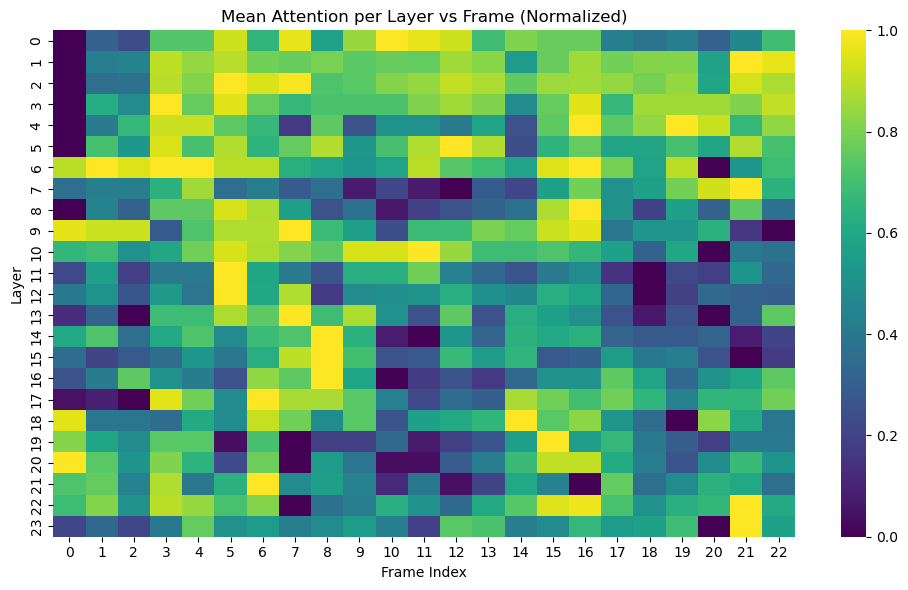

2025-09-16 20:18:19,841 - INFO - Saved layer-vs-frame attention matrix for 20000 [original] to layer_vs_frame_attention_20000_original.png


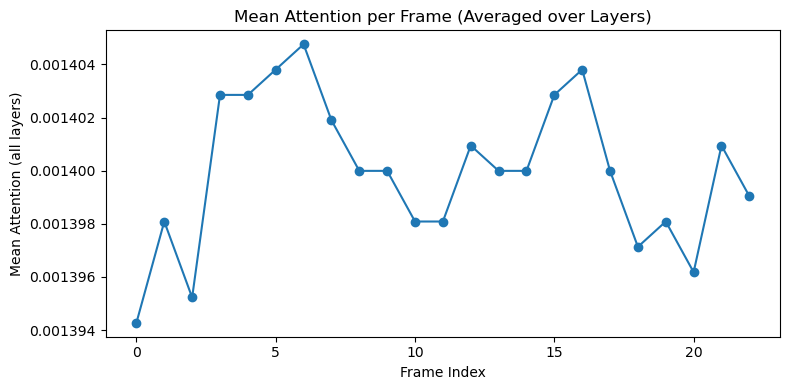

2025-09-16 20:18:19,974 - INFO - Generated response for 20000: USER: 
Answer the following questions about the video: 1.What does the hand push? 2.Is the cup uprig...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

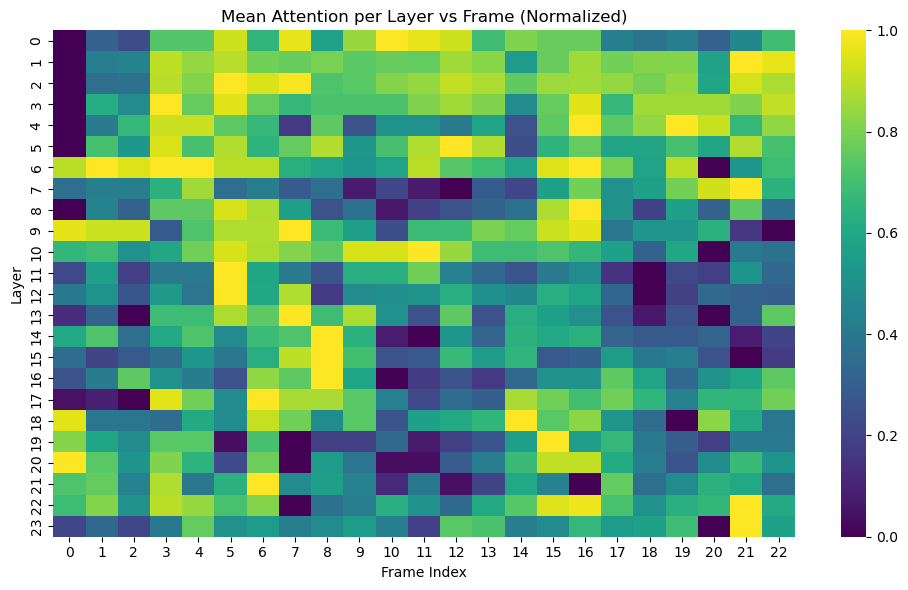

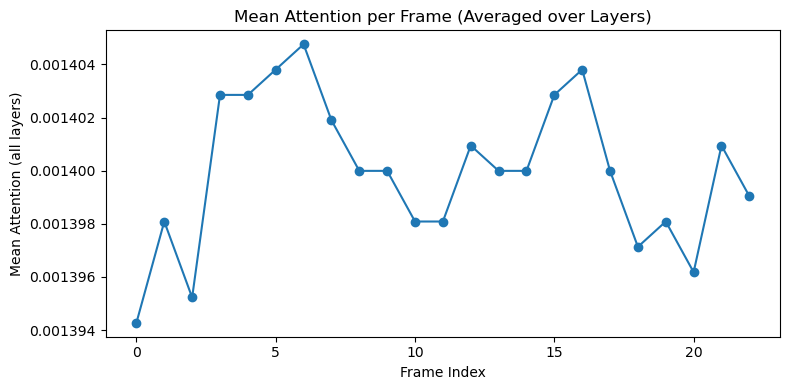

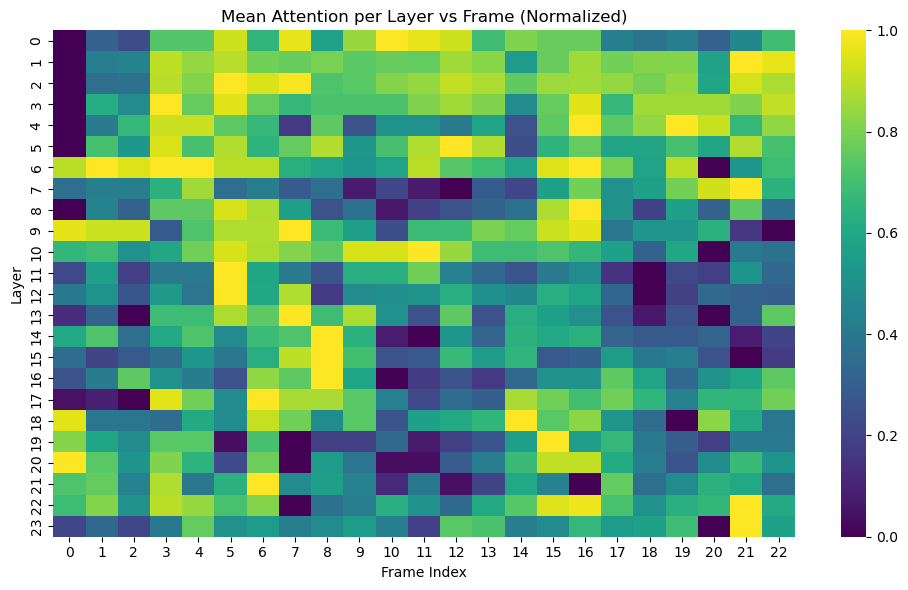

[INFO] Saved layer-vs-frame attention heatmap to /home/kassandralea.briola/Project/attention_layer_LLAva/20000/original/layer_vs_frame_attention.png


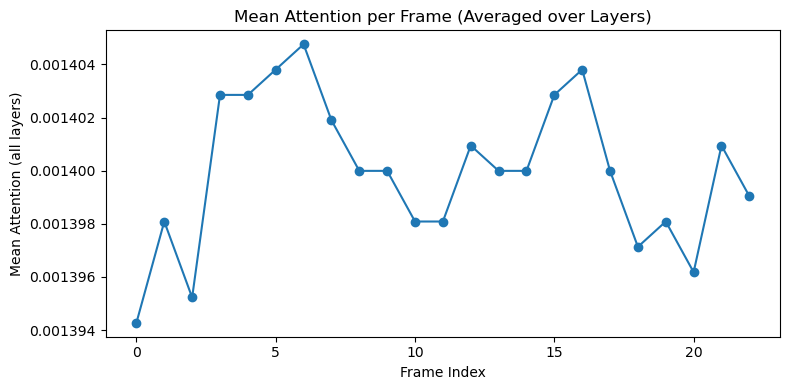

[INFO] Saved mean attention per frame plot to /home/kassandralea.briola/Project/attention_layer_LLAva/20000/original/mean_attention_per_frame.png


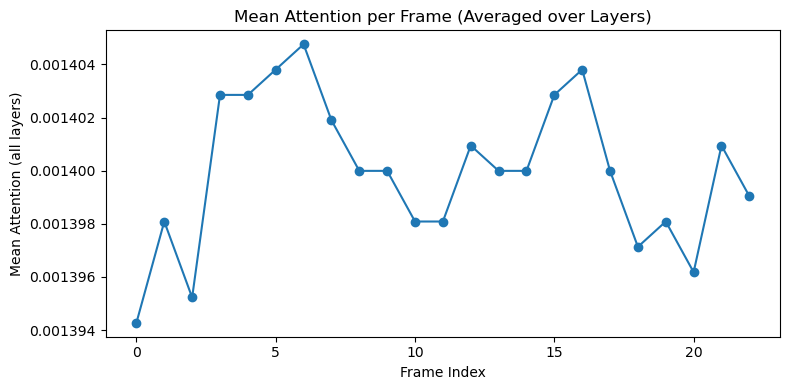

2025-09-16 20:18:27,328 - INFO - Starting analysis for /home/kassandralea.briola/Project/VideoCheck/20000.webm in mode crop-and-mask
2025-09-16 20:18:27,328 - INFO - Attempting to open video: /home/kassandralea.briola/Project/VideoCheck/20000.webm
2025-09-16 20:18:27,331 - INFO - Extracted 23 frames from /home/kassandralea.briola/Project/VideoCheck/20000.webm
2025-09-16 20:18:27,331 - INFO - Masks available from frame 0 to 45


Question Categories:
  Q1: categorical
  Q2: categorical
  Q3: categorical
  Q4: open-ended
  Q5: open-ended

Question: What does the hand push?
  - Category: categorical
  - Accuracy: 1.00
  - Semantic Similarity: 0.80
  - Model Answer: The hand pushes a cup off a table.
  - Ground Truth: The hand pushes a cup

Question: Is the cup upright or on its side at first?
  - Category: categorical
  - Accuracy: 1.00
  - Semantic Similarity: 0.87
  - Model Answer: The cup is initially upright, but it is tilted to the side before being pushed.
  - Ground Truth: The cup is upright at first

Question: Is the cup on or off the table before being pushed?
  - Category: categorical
  - Accuracy: 1.00
  - Semantic Similarity: 0.87
  - Model Answer: The cup is on the table before being pushed.
  - Ground Truth: The cup is on the table

Question: Why did the cup fall?
  - Category: open-ended
  - Accuracy: N/A
  - Semantic Similarity: 0.48
  - Model Answer: The cup falls off the table due to the force a

2025-09-16 20:18:27,534 - INFO - Video 20000.webm: 23 frames, 12.0 fps
2025-09-16 20:18:27,534 - INFO - Mask statistics: {'total_frames': 23, 'frames_with_masks': 23, 'first_masked_frame': 0}
2025-09-16 20:18:27,597 - INFO - Preparing inputs for 20000 in mode crop-and-mask
2025-09-16 20:18:27,599 - INFO - Padded all crop-and-mask frames to shape (240, 222, 3)
2025-09-16 20:18:27,600 - INFO - Video tensor shape before processing: (1, 23, 3, 240, 222)
2025-09-16 20:18:27,632 - INFO - Processor output keys: ['input_ids', 'attention_mask', 'pixel_values_videos']
2025-09-16 20:18:27,639 - INFO - Running model inference for 20000 in mode crop-and-mask


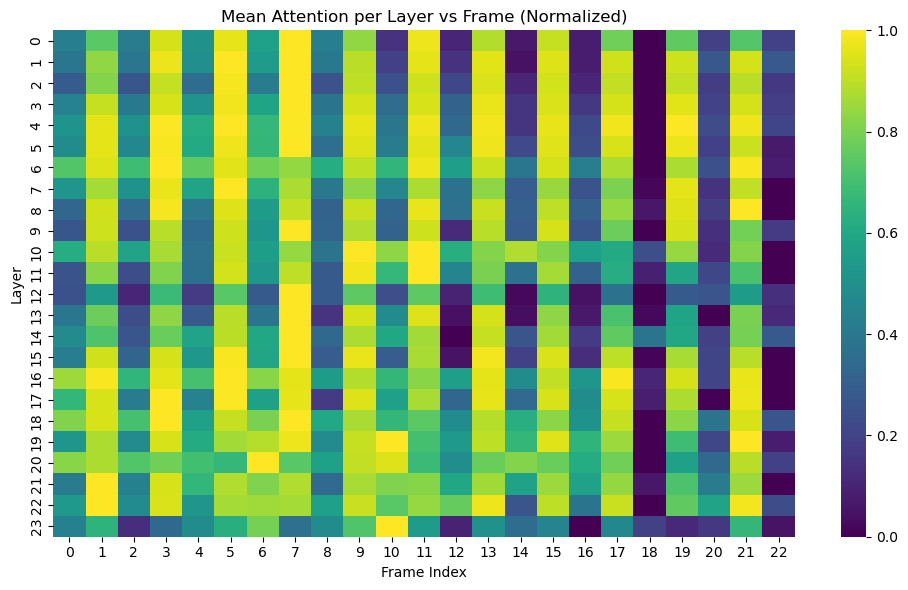

2025-09-16 20:18:33,337 - INFO - Saved layer-vs-frame attention matrix for 20000 [crop-and-mask] to layer_vs_frame_attention_20000_crop-and-mask.png


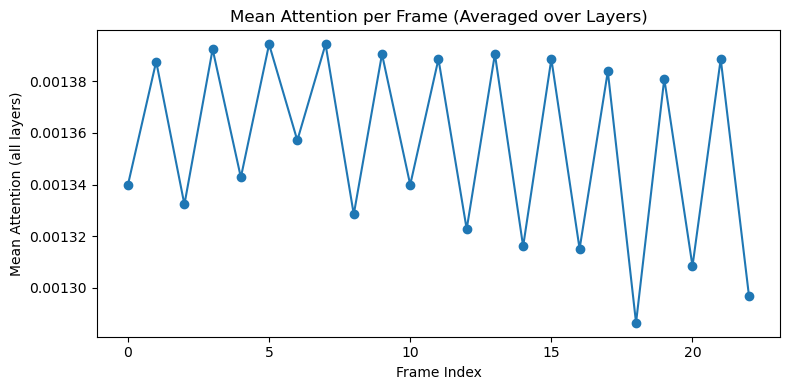

2025-09-16 20:18:33,467 - INFO - Generated response for 20000: USER: 
Answer the following questions about the video: 1.What does the hand push? 2.Is the cup uprig...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

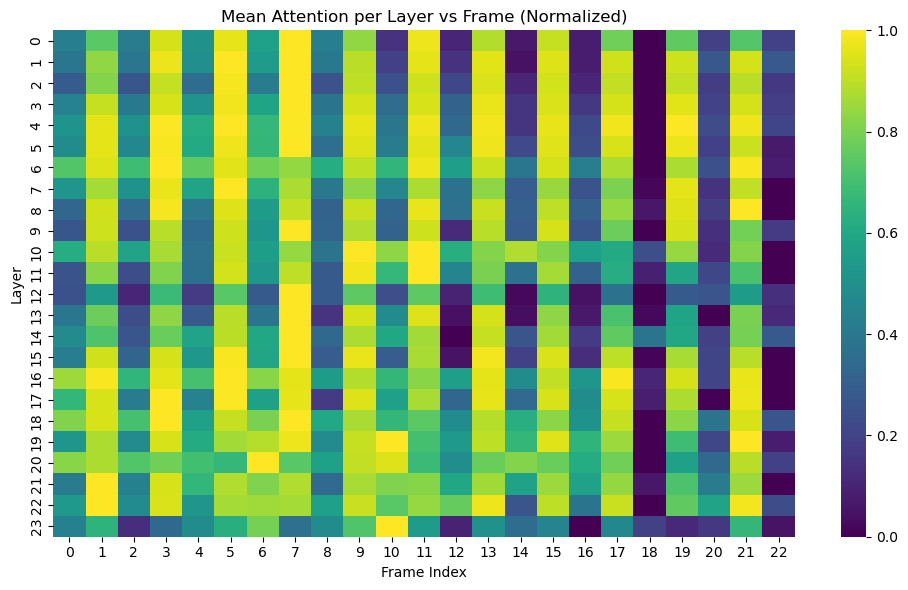

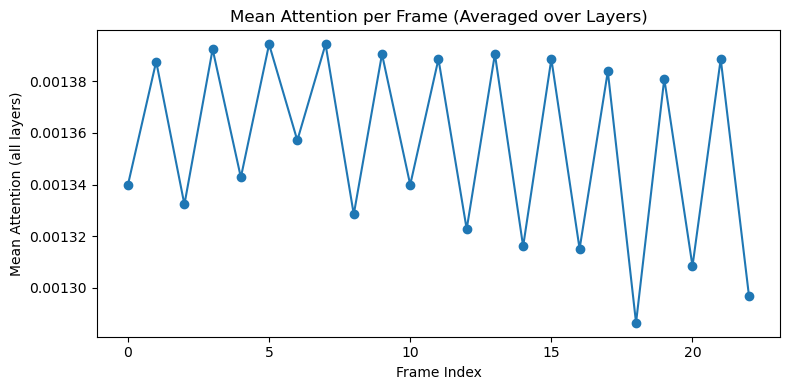

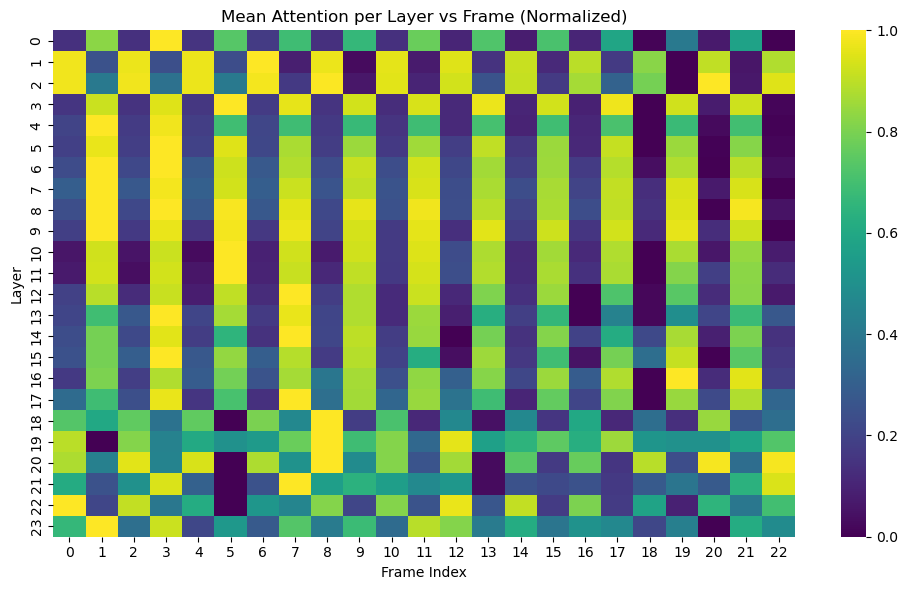

[INFO] Saved layer-vs-frame attention heatmap to /home/kassandralea.briola/Project/attention_layer_LLAva/20000/crop-and-mask/layer_vs_frame_attention.png


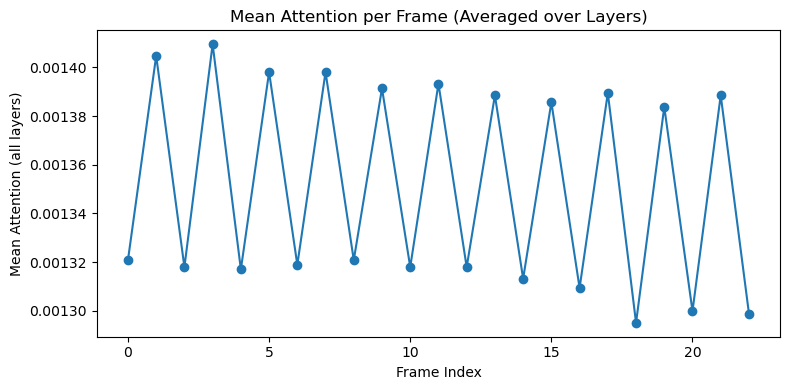

[INFO] Saved mean attention per frame plot to /home/kassandralea.briola/Project/attention_layer_LLAva/20000/crop-and-mask/mean_attention_per_frame.png


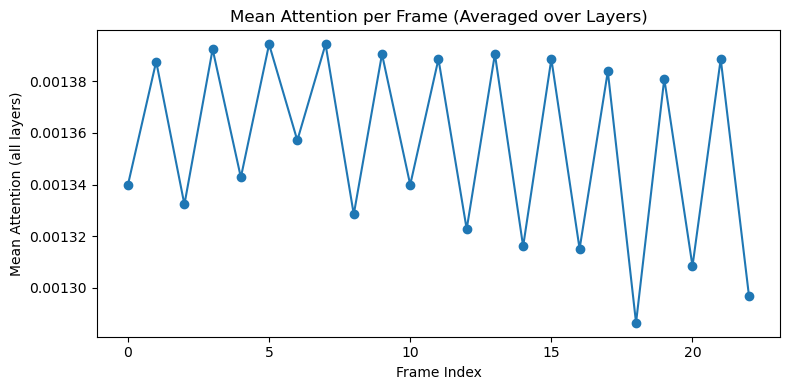

Question Categories:
  Q1: categorical
  Q2: categorical
  Q3: categorical
  Q4: open-ended
  Q5: open-ended

Question: What does the hand push?
  - Category: categorical
  - Accuracy: 1.00
  - Semantic Similarity: 0.77
  - Model Answer: The hand pushes the cup off the table.
  - Ground Truth: The hand pushes a cup

Question: Is the cup upright or on its side at first?
  - Category: categorical
  - Accuracy: 1.00
  - Semantic Similarity: 0.85
  - Model Answer: The cup is initially upright on the table.
  - Ground Truth: The cup is upright at first

Question: Is the cup on or off the table before being pushed?
  - Category: categorical
  - Accuracy: 1.00
  - Semantic Similarity: 0.87
  - Model Answer: The cup is on the table before being pushed.
  - Ground Truth: The cup is on the table

Question: Why did the cup fall?
  - Category: open-ended
  - Accuracy: N/A
  - Semantic Similarity: 0.48
  - Model Answer: The cup falls off the table due to the force applied by the hand.
  - Ground Tr

In [48]:
if __name__ == "__main__":
    try:
        torch.cuda.empty_cache()
        gc.collect()
        ModelLoader()
        interactive_analysis()
    except KeyboardInterrupt:
        print("\nProgram terminated by user.")
        sys.exit(0)